# IAM hands-on session from the 2019 AERE pre-conference Workshop

## 5. Monte Carlo

This section will demonstrate how you can run a Monte Carlo simulation of an existing model. In particular, we will run a Monte Carlo simulation of DICE2010, where we sample values for the climate sensitivity from a probability distribution.

As a first step, we are going to load a number of packages we are already familiar with, plus the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package, which contains definitions for a large number of probability distributions.

Note that we are currently working on a slightly simplified API for Monte Carlo simulations, so hopefully the examples in this section will become even easier to run in a few weeks.

In [1]:
using Distributions, DataFrames, Mimi, MimiDICE2010, VegaLite

The distribution we are going to use for climate sensitivity is a log normal distribution that is parameterized similarily to what was used in Gillingham et al. (2019). Here we plot the histogram for this particular distribution:

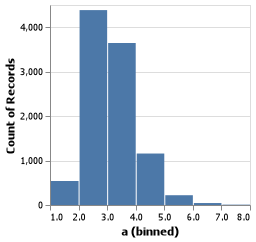

In [2]:
DataFrame(a = rand(LogNormal(1.10704, 0.264), 10000)) |> @vlplot(:bar, x={:a, bin=true}, y="count()")

To run a Monte Carlo simulation, we first create a simulation object with the `@defsim` macro that we assign to the variable `mcs`. Such a simulation object contains information about the probability distributions we want to sample from, how they should modify parameters of the model, and what output variables we want to save from the model.

In this example, we configure things such that the `t2xco2` parameter will receive values from a random variable that is log normally distributed, and we will save the `TATM` variable from the `climatedynamics` component.

In [3]:
mcs = @defsim begin
    t2xco2 = LogNormal(1.10704, 0.264)
    
    save(climatedynamics.TATM)
end

Simulation{MCSData}
  trials: 0
  current_trial: 0
  rvdict:
    t2xco2!1: RandomVariable{LogNormal{Float64}}
  translist:
    TransformSpec(:t2xco2, :(=), :t2xco2!1, Any[])
  savelist:
    (:climatedynamics, :TATM)


MCSData()

  nt_type: NamedTuple{(:t2xco2!1,),Tuple{Float64}}
  0 models
  1 results dicts


Next we generate a 1,000 samples from our uncertainty definition:

In [4]:
generate_trials!(mcs, 1_000)

The next step is that we create a new DICE2010 instance, and assign that to our simulation definition. We are essentially saying here that Mimi.jl should run this particular model in a Monate Carlo mode, with the uncertainty definition we created and stored in `mcs`.

In [5]:
set_models!(mcs, MimiDICE2010.get_model())

1-element Array{Dict{Tuple,DataFrame},1}:
 Dict()

Finally, we run our uncertainty simulation by calling the `run_sim` function, and storing the output of the simulation in a folder named `mcresults`.

In [6]:
run_sim(mcs, output_dir="mcresults")

Running 1000 trials for 1 scenarios...100%|█████████████| Time: 0:00:06


We can now load the actual values for the `TATM` variable from our Monte Carlo simulation from a CSV file that was written to disc with the `load` function from the [CSVFiles.jl](https://github.com/queryverse/CSVFiles.jl) package.

In [7]:
load("mcresults/TATM.csv")

60000x3 CSV file
time │ TATM    │ trialnum
─────┼─────────┼─────────
2005 │ 0.83    │ 1       
2015 │ 0.98    │ 1       
2025 │ 1.28594 │ 1       
2035 │ 1.57185 │ 1       
2045 │ 1.83833 │ 1       
2055 │ 2.08507 │ 1       
2065 │ 2.31232 │ 1       
2075 │ 2.52103 │ 1       
2085 │ 2.71266 │ 1       
2095 │ 2.8889  │ 1       
... with 59990 more rows

Note how we have an extra column named `trialnum` here, that references the Monte Carlo run for each value.

We will next use the package [Query.jl](https://github.com/queryverse/Query.jl) to manipulate the results from our Monte Carlo runs and then visualize them with [VegaLite.jl](https://github.com/queryverse/VegaLite.jl). [Query.jl](https://github.com/queryverse/Query.jl) is a package similar to R's dplyr, just for Julia.

In [8]:
using Query

In particular, here we filter the table that was written for the `TATM` variable to only include values for the yar 2095, and then plot a histogram of those values, namely a histogram for the temperature increase in the year 2095 that our Monte Carlo simulation created.

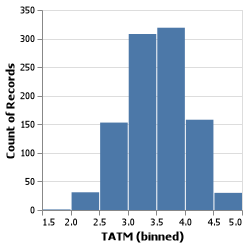

In [9]:
load("mcresults/TATM.csv") |> @filter(_.time==2095) |> @vlplot(:bar, x={:TATM, bin=true}, y="count()")

We can also use simulation definitions that are fully specified in the model package. For exmaple, PAGE09 has a full uncertainty specification out-of-the-box. In the following example we will use that to run a Monte Carlo simulation of PAGE.

First we load PAGE:

In [10]:
using MimiPAGE2009

Next we load the simulation definition from the PAGE package by calling the `getsim` function in that package. This essentially replaces the `@defsim` call we used above, and instead returns the uncertainty specification that the model developers for PAGE created:

In [11]:
msc_page = MimiPAGE2009.getsim();

The remaining steps are the same as in the previous example:

In [12]:
generate_trials!(msc_page, 1_000)
set_models!(msc_page, MimiPAGE2009.get_model())
run_sim(msc_page, output_dir="mcresults2")

Running 1000 trials for 1 scenarios...100%|█████████████| Time: 0:00:18


Again, note that we are currently working on a slightly simplified API for Monte Carlo simulations, so hopefully the examples in this section will become even easier to run in a few weeks.